In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# initialize the initial learning rate
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:

# For Linux
# DIRECTORY = r"/home/apple/Desktop/Face_Mask_Project/dataset/"

DIRECTORY = r"/content/drive/MyDrive/Colab Notebooks/Face Mask Detection Dataset/Face Mask Detection Dataset/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
# grab the list of images in our dataset directory, then initialize
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
# convert text to Binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 [==============================] - 2s 0us/step


In [9]:
# Create head and the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [11]:
# Call head and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
	layer.trainable = False

In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

print("Compilation of the MODEL is going on...")

lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


Compilation of the MODEL is going on...


In [15]:
# train the head of the network
print("Training Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Training Head Started...
Epoch 1/20
95/95 [==============================] - 43s 329ms/step - loss: 0.3759 - accuracy: 0.8537 - val_loss: 0.1555 - val_accuracy: 0.9648
Epoch 2/20
95/95 [==============================] - 31s 329ms/step - loss: 0.1443 - accuracy: 0.9644 - val_loss: 0.0884 - val_accuracy: 0.9726
Epoch 3/20
95/95 [==============================] - 30s 316ms/step - loss: 0.0895 - accuracy: 0.9756 - val_loss: 0.0686 - val_accuracy: 0.9765
Epoch 4/20
95/95 [==============================] - 30s 317ms/step - loss: 0.0733 - accuracy: 0.9792 - val_loss: 0.0579 - val_accuracy: 0.9765
Epoch 5/20
95/95 [==============================] - 30s 315ms/step - loss: 0.0630 - accuracy: 0.9825 - val_loss: 0.0510 - val_accuracy: 0.9791
Epoch 6/20
95/95 [==============================] - 30s 314ms/step - loss: 0.0471 - accuracy: 0.9852 - val_loss: 0.0486 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 30s 314ms/step - loss: 0.0540 - accuracy: 0.9842 - val_loss: 0.04

In [16]:
# make predictions on the testing set
print("Network evaluation...")
predIdxs = model.predict(testX, batch_size=BS)

Network evaluation...
24/24 [==============================] - 1s 13ms/step


In [17]:
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

saving mask model...


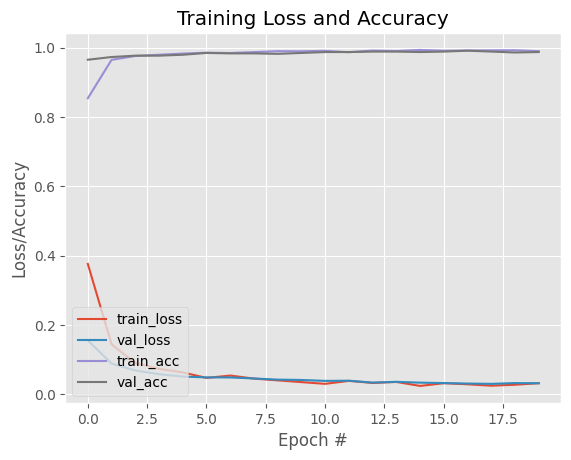

In [18]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")